NomicEmbeddings

Rag with metadata

Human in the loop

--------------------

patients identity hidden from llm

using python Relp for relative month in profile or policy comply

add database to google api

utilities:   
- patients DB creator

steps:
- Create Agents
- Define tools
- Create graph
- Define Agent Nodes
- Define Tool Node
- Define Edge Logic
- Define the Graph
- show the graph
- Invoke
  
- Human in the loop
- Maximum number of steps
- Helper Utilities

# LLM Agents for Clinical Trial Management

In this notebook, we develop an agent-based system to automate the management and analysis of clinical trial data, ensuring compliance with regulatory standards, and providing comprehensive reports for stakeholders. This pipeline also incorporate human-in-the-loop (HITL) and memory mechanisms to enhance functionality and accuracy.

## Steps and Plan

1. Define the Problem:

Objective: Automate clinical trial data management, analysis, compliance checks, and reporting.

Key Components: Data collection, data analysis, compliance verification, reporting, and human-in-the-loop interventions.

2. Design the Architecture:
**Agents:**
Data Collection Agent: Gathers patient data, trial results, and other relevant information.

Data Analysis Agent: Analyzes the collected data to generate reports on trial outcomes.

Compliance Agent: Ensures all data and processes adhere to regulatory standards.

Reporting Agent: Compiles and presents the analysis findings in comprehensive reports.

Human-in-the-Loop: Integrate a review phase where human experts validate data analysis and compliance checks before final reporting.

Memory: Utilize LangGraph’s memory capabilities to track the progress and history of each trial.

The Clinical Trial Matching Agent is designed to match patients wit	h suitable clinical trials based on their medical history, symptoms, and ongoing treatments. This application helps patients find relevant clinical trials they may be eligible for, improving their chances of accessing new treatments and contributing to medical research.


1. Database Setup
- SQLite Database: Create two databases:
- Patients DB: Stores patient medical history, previous trials, and other relevant data.
- Clinical Trials DB: Contains information about ongoing and upcoming clinical trials, including eligibility criteria.
2. Agents and Tools
- Patient Data Ingestion Agent: Retrieves patient data from the SQLite database or prompts the user to provide missing data.
- Data Validation and Collection Loop: Ensures all required fields are collected using persistence.
- Policy Compliance Agent: Cross-checks patient data with institutional policies.
- Trial Vectorization Agent: Extracts and vectorizes recruiting trials for efficient search.
- Trial Matching Agent: Forms prompts from patient data to search the vector database for potential trial matches.
- Human-in-the-Loop (HIL) Agent: Presents top trial matches to the user for selection.
- Persistence Mechanism: Allows the application to save and resume states, especially useful for collecting patient data and searching trials.

In [2]:
%load_ext autoreload
%autoreload 2
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

# Parameters

In [3]:
from langchain_openai import ChatOpenAI


policy_vstore_created = False
trials_vstore_created = False
trials_db_downloaded = False
chromadb_path = "../../chroma_db"
policy_collection = "policy-chroma"
trial_collection = "trial-chroma"

modelID = "gpt-3.5-turbo"
n_retrieved_policies = 6
# n_retries = 6
n_retrieved_trials = 6



model = ChatOpenAI(temperature = 0.0, model=modelID)

In [4]:
# import os

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

# Creating the sample datasets

## Patients database

In [5]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import random

# Generate the sample data again for display
columns = ["patient_id", "name", "age", "medical_history", "previous_trials", "trial_status", "trial_completion_date"]
data = []

# Given names and surnames
names = ["John", "Jane", "Alice", "Michael", "Emily", "Daniel", "Sophia", "James", "Emma", "Oliver"]
surnames = ["Doe", "Smith", "Johnson", "Brown", "Davis", "Garcia", "Martinez", "Anderson", "Thomas", "Wilson"]

# Generate all possible unique combinations of names and surnames
combinations = [(name, surname) for name in names for surname in surnames]

# Shuffle the combinations to ensure randomness
random.shuffle(combinations)

# Select the first 100 unique combinations
unique_names = combinations[:100]

# Generate the full names
full_names = [f"{name} {surname}" for name, surname in unique_names]

with open('../../source_data/diseases_list.json', 'r') as file:
        trial_diseases =  json.load(file)

list_trial_diseases = list({disease for diseases in trial_diseases.values() for disease in diseases})

other_medical_conditions = ["Hypertension", "Diabetes", "Asthma", "Heart Disease", "Arthritis",
                      "Chronic Pain", "Anxiety", "Depression", "Obesity"]

all_conditions = list(set(list_trial_diseases + other_medical_conditions))

trial_statuses = ["Completed", "Ongoing", "Withdrawn"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# start_date must be 2 years before now
start_date = datetime.now() - timedelta(days=365 * 2)
# start_date = datetime(2020, 1, 1)

# end_date must be a month before now
end_date = datetime.now() - timedelta(days=10)
# end_date = datetime(2023, 1, 1)

for i in range(1, 101):
    name = random.choice(full_names)
    age = random.randint(20, 80)
    medical_history = random.choice(all_conditions)
    
    if random.choice([True, False]):
        previous_trials = f"NCT0{random.randint(1000000, 9999999)}"
        trial_status = random.choice(trial_statuses)
        trial_completion_date = random_date(start_date, end_date).strftime('%Y-%m-%d')
    else:
        previous_trials = ""
        trial_status = ""
        trial_completion_date = ""
    if trial_status == "Ongoing":
        trial_completion_date = ""

    data.append((i, name, age, medical_history, previous_trials, trial_status, trial_completion_date))

df = pd.DataFrame(data, columns=columns)
# save df to csv
df.to_csv("patients.csv", index=False)
df.head(20)

,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Jane Thomas,37,peritoneal cancer,NCT03710197,Ongoing,
1,2,Sophia Thomas,56,Obesity,,,
2,3,Michael Thomas,40,Diabetes,,,
3,4,Daniel Doe,44,suicidal ideation,NCT08404176,Withdrawn,2023-07-31
4,5,Sophia Johnson,64,lung cancer,NCT08487833,Withdrawn,2023-08-05
5,6,Daniel Thomas,66,solid tumors,NCT04103469,Ongoing,
6,7,Jane Wilson,74,liposarcoma,NCT04959533,Completed,2023-08-02
7,8,James Smith,60,anxiety disorder,NCT01052103,Completed,2023-12-12
8,9,Jane Brown,62,colorectal cancer,NCT05825583,Withdrawn,2023-12-03
9,10,Jane Brown,44,Depression,NCT08548726,Ongoing,


In [6]:
import os
import sqlite3
import pandas as pd

overwrite = True

database_file = 'patients_database.db'
df = pd.read_csv('patients.csv')
if overwrite or not os.path.exists(database_file):
    if os.path.exists(database_file):
        os.remove(database_file)
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS patients (
        patient_id INTEGER PRIMARY KEY,
        name TEXT,
        age INTEGER,
        medical_history TEXT,
        previous_trials TEXT,
        trial_status TEXT,
        trial_completion_date TEXT
    )
    ''')

    # Insert DataFrame into SQLite table
    df.to_sql('patients', conn, if_exists='append', index=False)

    # Commit and close the connection
    conn.commit()
else:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Jane Thomas,37,peritoneal cancer,NCT03710197,Ongoing,None
1,2,Sophia Thomas,56,Obesity,None,None,None
2,3,Michael Thomas,40,Diabetes,None,None,None
3,4,Daniel Doe,44,suicidal ideation,NCT08404176,Withdrawn,2023-07-31
4,5,Sophia Johnson,64,lung cancer,NCT08487833,Withdrawn,2023-08-05
5,6,Daniel Thomas,66,solid tumors,NCT04103469,Ongoing,None
6,7,Jane Wilson,74,liposarcoma,NCT04959533,Completed,2023-08-02
7,8,James Smith,60,anxiety disorder,NCT01052103,Completed,2023-12-12
8,9,Jane Brown,62,colorectal cancer,NCT05825583,Withdrawn,2023-12-03
9,10,Jane Brown,44,Depression,NCT08548726,Ongoing,None


## Clinical Trials database

In [7]:
import sys
module_dir = os.path.abspath('../../src')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_functions import dataset_create_trials

overwrite = False
if trials_db_downloaded and not overwrite:
    print(f'Trials database already downloaded and stored in {trials_path}')
    df_trials = pd.read_csv(trials_path)
else:
    df_trials, trials_path = dataset_create_trials(status='recruiting')
    trials_db_downloaded = True

# print the ctriteria column value froom 4 random rows of the dataferam. use a for loop
df_samples = df_trials.sample(4).reset_index(drop=True)
for i in range(4):
    print(f'---- Sample {i+1} ----')
    print(df_samples.iloc[i]['criteria'])


Only trials with status recruiting are selected.
The database for trials is saved to ../../data/trials_data.csv 
 It has 30 rows.
---- Sample 1 ----

        Key Inclusion Criteria:

          -  Subject must be ≥18 years of age.

          -  Subjects must have documented IDH1 R132 gene-mutated advanced hematologic malignancy
             based on local or central evaluation.

          -  Subjects must be amenable to serial bone marrow biopsies, peripheral blood sampling,
             and urine sampling during the study.

          -  Subjects must have ECOG PS of 0 to 2.

          -  Platelet count ≥20,000/µL (Transfusions to achieve this level are allowed).

          -  Subjects must have adequate hepatic function as evidenced by: Aspartate
             aminotransferase (AST), alanine aminotransferase (ALT), and alkaline phosphatase (ALP)
             ≤3.0 × ULN, unless considered due to leukemic disease and serum total bilirubin ≤1.5 x
             upper limit of normal (ULN), u

# Creating Vectore Stores

## vectorstore for policy database

local embedding via NomicEmbeddings

In [8]:
import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document
import chromadb

# vstore_delete = False
vstore_load = True
markdown_path = "../../source_data/instut_trials_policy.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()


doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

print(len(doc_splits))
doc_splits

persistent_client = chromadb.PersistentClient(path = chromadb_path)

if vstore_load == False:
    vectorstore.delete_collection()


# if chromadb_path exists
if os.path.exists(chromadb_path) and vstore_load:
    vectorstore = Chroma(
        client=persistent_client,
        collection_name=policy_collection,
        embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    print('Vectore store loaded from existing chromadb')
    # vectorstore._collection.count()
else:
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        client=persistent_client,
        collection_name=policy_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    print('Vectore store created and stored in persistent chromadb client')
print(vectorstore._collection.count())
doc_splits


12
Vectore store loaded from existing chromadb
12


[Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All patients must provide informed consent prior to participation.\n   - **Residency**: Patients must be residents of the country where the trial is conducted.\n   - **Health Insurance**: Patients must have valid health insurance coverage.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 2. **Medical History Restrictions**\n   - **Severe Heart Disease** (e.g., recent myocardial infarction, heart failure)\n   - **Uncontrolled Diabetes Mellitus**     \n   - **Recent Surgeries**: Patients who have undergone major surgery within the current year are not eligible.   \n   - **Infectious Diseases**: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specificall

In [9]:
os.path.exists(chromadb_path)

True

In [10]:
retriever_policy = vectorstore.as_retriever(search_kwargs={"k": n_retrieved_policies})
# question = "policy about patient's past trials"
question = "\ntrial_completion_date: 2024-04-01"
docs_retrieved = retriever_policy.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
print(doc_txt)
docs_retrieved

6

#### 3. **Previous Trial Participation**   
   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.
   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.
   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the past 5 months from now.
   - **Trial Outcomes**:
     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.
     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.



[Document(page_content='\n#### 3. **Previous Trial Participation**   \n   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.\n   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.\n   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the past 5 months from now.\n   - **Trial Outcomes**:\n     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.\n     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 4. **Medication and Treatment Restrictions**\n   - **Concurrent Medications**: Patients must not be on any medication

## Vstore for trials

we just work on 3 main categories of cancer, lukemia, and mental health problems as a demo application.

For a more proper application, this must be done with the help of domain specialists.

In [11]:
# from langchain.document_loaders import CSVLoader
# file = '../../data/trials_data.csv'
# df_trials = pd.read_csv(file)
from helper_functions import disease_map

vstore_delete = False

trial_docs = []
for i, row in df_trials.iterrows():
    disease = disease_map(row['diseases'])
    if disease == 'other_conditions':
        continue
    doc = Document(
        page_content=row['criteria'],
        metadata={
            "nctid": row['nctid'],
            "status": row['status'],
            # "why_stop": row['why_stop'],
            # "label": row['label'],
            # "phase": row['phase'],
            "diseases": str(row['diseases']),
            "disease_category": disease[0],
            "drugs": row['drugs'],            
        }
    )
    trial_docs.append(doc)
# trial_docs

print(trial_docs[0].metadata)

list_remove = set()
for i, doc in enumerate(trial_docs):
    if len(doc.page_content)>10000:
        list_remove.add(i)
        # print(doc.metadata)
    if doc.metadata['disease_category'] == 'other_conditions':
        list_remove.add(i)
        # print(doc.metadata)
# remove list_remove indexes from trial_docs
trial_docs = [doc for i, doc in enumerate(trial_docs) if i not in list_remove]

# print(len(trial_docs[11].page_content))
# trial_docs.pop(11)

persistent_client = chromadb.PersistentClient(path = chromadb_path)


if vstore_delete == True:
    vectorstore_trials.delete_collection()
    trials_vstore_created = False
    vstore_delete = False
    print("vstore deleted")

# if chromadb_path exists
# if trials_vstore_created:

vectorstore_trials = Chroma(
    client=persistent_client,
    collection_name=trial_collection,
    embedding_function=NomicEmbeddings(model="nomic-embed-text-v1.5",
                            inference_mode='local'),
)
if vectorstore_trials._collection.count() == 0:
    vectorstore_trials = Chroma.from_documents(
        documents=trial_docs,
        client=persistent_client,
        collection_name=trial_collection,
        # persist_directory=chromadb_path,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
    )
    trials_vstore_created = True
    print("Vectorstore is created now")
else:
    print("Loading the vectorstore from persistent client")

print(vectorstore_trials._collection.count())
trial_docs


{'nctid': 'NCT00715611', 'status': 'recruiting', 'diseases': "['mesothelioma']", 'disease_category': 'cancer', 'drugs': "['pemetrexed and cisplatin or carboplatin']"}
Loading the vectorstore from persistent client
18


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Provide written informed consent to participate on the study\r\n\r\n          -  Patients must have a pathologically confirmed diagnosis either at MSKCC or at the\r\n             participating site of stage I-III malignant pleural mesothelioma\r\n\r\n          -  Epithelioid or biphasic histology subtype (Note: patients with biphasic histology can\r\n             have < 10% sarcomatoid)\r\n\r\n          -  No evidence of metastatic disease.\r\n\r\n          -  Patient age ≥ 18 years but ≤ 80 years at the time of consent.\r\n\r\n          -  Karnofsky performance status ≥ 80%\r\n\r\n          -  Pulmonary Function Tests:\r\n\r\n               1. For all patients: DLCO > 40% predicted (corrected for Hgb)\r\n\r\n               2. For patients enrolled post-P/D, only: FEV1 >/= 35% (corrected for Hgb) (Note:\r\n                  patients enrolled prior to P/D will have PFTs repeated pre-IMRT. If this criteria\r\n     

### Retriever Trials

In [12]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="disease_category",
        description="Defines the disease group of patients related to this trial. One of ['cancer', 'leukemia', 'mental_health']",
        # description="The trial is for patients when their disease is related to this category. One of ['cancer', 'leukemia', 'mental_health']",
        type="string",
    ),
    AttributeInfo(
        name="drugs",
        description="List of drug names used in the trial",
        type="str",
    ),    
]

document_content_description = "The list of patient conditions to include or exclude them from the trial"
retriever_trial_sq = SelfQueryRetriever.from_llm(
    model,
    vectorstore_trials,
    # vectorstore_trials_mpnet,
    document_content_description,
    metadata_field_info
    # enable_limit=True
)

In [13]:
retriever_trials = vectorstore_trials.as_retriever(search_kwargs={"k": n_retrieved_trials})
# question = trial_docs[trail_smp].page_content
question = """
Which trials are relevant to patient who has adenocarcinoma illness?
"""

# question = f"""
# Which trials are relevant to the patient with the following medical history?\n
# patient_profile: {patient_profile}
# """
# nprint(question)

# Which four trials are for patients with mental problem?
# print(trial_docs[trail_smp].metadata['nctid'])
# question = "Inclusion Criteria:\r\n\r\n          1. Subject"
docs_retrieved = retriever_trials.get_relevant_documents(question)
# docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

6
cancer ['prostate cancer']
cancer ['metastatic pancreatic cancer']
cancer ['rectal cancer']
cancer ['colorectal cancer']
cancer ['pancreatic ductal adenocarcinoma']
cancer ['stage iv non-small cell lung cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed metastatic or advanced prostate adenocarcinoma that has been\r\n             previously treated with docetaxel-based therapy and has progressed during treatment of\r\n             at least one hormonal therapy(prior docetaxel is not required for the safety cohort)\r\n\r\n          -  Two rising PSA levels greater than or equal to (>/=) 2 ng/mL measured >/= 1 week apart\r\n             or radiographic evidence of disease progression in soft tissue or bone\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performance status of 0 or 1 at screening\r\n\r\n          -  Adequate hematologic and organ function\r\n\r\n          -  Documented willingness to use an effective means of contraception\r\n\r\n          -  Safety cohort only: agreement to use CGM for first cycle of treatment\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  History of Type I or Type II diabetes mellitus 

# Tools:

In [14]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

def get_patient_data(patient_id: int) -> dict:
    """Fetch all fields for the patient based on the given patient_id as an integer.

    Returns:
        A dictionary containing the patient's medical history.        
    """

    # config = ensure_config()  # Fetch from the context
    # configuration = config.get("configurable", {})
    # patient_id = configuration.get("patient_id", None)

    # if not patient_id:
    #     raise ValueError("No patient ID given.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()    
    query = 'SELECT * FROM patients WHERE patient_id=?'
    cursor.execute(query, (patient_id,))
    patient_data = cursor.fetchone()
    # rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    conn.close()
    if patient_data is None:
        return None
    else:    
        results = dict(zip(column_names, patient_data))    
    return results


def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()

In [15]:
sample_patient_id = 4
patient_data = get_patient_data(sample_patient_id)
print(patient_data)
patient_data

{'patient_id': 4, 'name': 'Daniel Doe', 'age': 44, 'medical_history': 'suicidal ideation', 'previous_trials': 'NCT08404176', 'trial_status': 'Withdrawn', 'trial_completion_date': '2023-07-31'}


{'patient_id': 4,
 'name': 'Daniel Doe',
 'age': 44,
 'medical_history': 'suicidal ideation',
 'previous_trials': 'NCT08404176',
 'trial_status': 'Withdrawn',
 'trial_completion_date': '2023-07-31'}

dummy : profile creator llm

In [16]:
def patient_data_to_string(patient_data):
    return " \n ".join([f"{key}: {value}" for key, value in patient_data.items()])

patient_id = 2
patient_data = get_patient_data(patient_id)
patient_data
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}

# patient_medical_history = patient_data_to_string(patient_data)


{'patient_id': 2,
 'name': 'Sophia Thomas',
 'age': 56,
 'medical_history': 'Obesity',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

### Profile Creator

In [17]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
parser = StrOutputParser()

# def patient_data_to_string(patient_data):
    # return " \n".join([f"{key}: {value}" for key, value in patient_data.items()])

prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of patient information.
    The patient profile also suggests relevant medical trials based on patient's medical history.
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}
if patient_data.get('name'):
    del patient_data['name']
    del patient_data['patient_id']
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient is a 56-year-old with a history of obesity. No previous trials or '
 'current trial status. Potential trials for obesity management may be '
 'suitable for this patient.')


In [18]:
question = f"""
Which trials are relevant to the patient with the following medical history?\n
patient_profile: {patient_profile}
"""
# patient_profile: {patient_profile}
# question = """
# Which trials are relevant to the patient with the medical history of myeloid leukemia?
# """
nprint(question)

# docs_retrieved = retriever_trials.get_relevant_documents(question)
docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

('\n'
 'Which trials are relevant to the patient with the following medical '
 'history?\n'
 '\n'
 'patient_profile: Patient is a 56-year-old with a history of obesity. No '
 'previous trials or current trial status. Potential trials for obesity '
 'management may be suitable for this patient.\n')
4
cancer ['prostate cancer']
cancer ['esophageal adenocarcinoma', 'gastric adenocarcinoma', 'stage iib gastric cancer', 'stage iiia esophageal adenocarcinoma', 'stage iiia gastric cancer', 'stage iiib esophageal adenocarcinoma', 'stage iiib gastric cancer', 'stage iiic esophageal adenocarcinoma', 'stage iiic gastric cancer']
leukemia ['myelodysplastic syndromes', 'chronic myelomonocytic leukemia', 'acute myeloid leukemia']
cancer ['multiple myeloma']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed metastatic or advanced prostate adenocarcinoma that has been\r\n             previously treated with docetaxel-based therapy and has progressed during treatment of\r\n             at least one hormonal therapy(prior docetaxel is not required for the safety cohort)\r\n\r\n          -  Two rising PSA levels greater than or equal to (>/=) 2 ng/mL measured >/= 1 week apart\r\n             or radiographic evidence of disease progression in soft tissue or bone\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performance status of 0 or 1 at screening\r\n\r\n          -  Adequate hematologic and organ function\r\n\r\n          -  Documented willingness to use an effective means of contraception\r\n\r\n          -  Safety cohort only: agreement to use CGM for first cycle of treatment\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  History of Type I or Type II diabetes mellitus 

### profile maker

In [19]:
parser = StrOutputParser()
prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of patient information.
    The patient profile also suggest relevant medical trials based on patient's medical history.
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser

# to preserve the patient's private information
if patient_data.get('name'):
    del patient_data['patient_id']
    del patient_data['name']

patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile) # patient_profile

('Patient Profile:\n'
 'The patient is a 56-year-old with a history of obesity. They have not '
 'participated in any previous trials and their trial status and completion '
 'date are currently unknown.\n'
 '\n'
 "Based on the patient's medical history of obesity, relevant medical trials "
 'may include studies on weight management, obesity treatments, or lifestyle '
 'interventions for improving overall health. It is important to consider '
 'trials that focus on addressing obesity-related health concerns in this '
 'patient population.')


In [20]:
patient_profile = """
Patient is an 76-year-old individual with a history of leiomyosarcoma. 
They have previously participated in the clinical trial NCT03923948, which has been completed as of April 13, 2024. 
Based on their medical history, relevant trials may include those focused on sarcoma treatments or geriatric oncology.
"""

### policy checker

In [21]:
import langchain
from langchain import hub
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain.prompts import PromptTemplate
from operator import itemgetter
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.agents import AgentExecutor, create_openai_tools_agent
from typing import Annotated




@tool
def python_repl(
    code: Annotated[str, "The python code to execute. The code must ALWAYS end print the output using `print(...)` as the last line to see the result."],
):
    """A Python shell. Use this to execute python commands. 
    Input should be a valid python command. 
    If you want to see the output of a value, you should print it out with `print(...)`."""
    try:
        result = repl.run(code)
        # return result
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        # result_str
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


# patient_profile = patient_data_to_string(patient_data)

# print(patient_profile)
model = ChatOpenAI(temperature = 0.0, model="gpt-3.5-turbo")
langchain.debug = False

question = f"""
Does the following patient profile comply with the institutional policies?\n
{patient_profile}
"""

# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

from langchain.chains import RetrievalQA


class comply(BaseModel):
        """Binary score for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trials 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use NA")
        
llm_with_tool = model.with_structured_output(comply)

# docs_retrieved = retriever_policy.get_relevant_documents(question)
docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
# docs = docs_retrieved[5].page_content
# docs = docs_retrieved[1].page_content
# for doc in docs_retrieved:


prompt_repl = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Principal Investigator (PI) for evaluating patients for clinical trials." 
            "You compare the patient profile to the institution policies to determine if the patient is eligible for clinical trials or not."
            # "Use the following institution policy(s) to find if the patient is eligibile for trials."
            "\n #### Here is the patient profile: \n {patient_profile}\n\n"
            # "\n Here is/are the retrieved policy(s) document: \n {context}\n\n"

            "-------------------\n"
            
            "Restrict your judgment Only to the information given in patient's profile and the policy given by the user\n"
            # "Restrict your judgment Only to the above retrieved policy(s) and the information in patient's profile by the user\n"
            # "You are a helpful AI assistant."
            # "You may generate safe python code to do numerical operations and data conversions." 
            # "To see the result of the code execution, print the output value at thr end with `print(...)`"
            "You have access to the following tools: {tool_names}."
            "\n You may generate only safe python code."
            # "\n Use python code ONLY IF if the retrieved policy document contain numerical or time related information.", 
        ),
        # MessagesPlaceholder(variable_name="examples"),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
        (
            "system",
            "Note: Current date is {date}.\n"

            "Give a binary 'yes' or 'no' score in the response to indicate whether the patient is eligible for clinical trials."
            "If the patient is not eligible then also include the reason in your response."
            # Use it as the reference date to evaluate time related regulations."
        ),
        MessagesPlaceholder(variable_name="examples"),
    ]
)


prompt_repl = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Principal Investigator (PI) for evaluating patients for clinical trials." 
            "You compare the patient profile to the clinical trial policies to determine if the patient is eligible for clinical trials or not."            
            
            "Read the input information about the patient profile and relevant clinical trial policies: \n"            
                                   
            "can you determine if patient is eligible for clinical trials?\n"
            "if you can't say I can't\n"
            "You have access to the following tools: {tool_names}."
            "\n You may generate only safe python code. ALWAYS print the output using `print(...)` as the last line."
            # "\n Use python code ONLY IF if the retrieved policy document contain numerical or time related information.", 
        ),
        # MessagesPlaceholder(variable_name="examples"),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
        (
            "system",
            "Note: Current date is {date}.\n"

            # "Give a binary 'yes' or 'no' score in the response to indicate whether the patient is eligible for clinical trials."
            # "If the patient is not eligible then also include the reason in your response."
            # Use it as the reference date to evaluate time related regulations."
        ),
        MessagesPlaceholder(variable_name="examples"),
    ]
)

examples = """
Example of date comparison:
query: is November 25, 2023 within the 5 months before the current date, 25-03-2024?

generated code:
```
gap_months = 5
today = datetime.strptime('25-03-2024', '%d-%m-%Y')
trial_completion_date = datetime.strptime('25-11-2023', '%d-%m-%Y')
days_difference = (today - trial_completion_date).days
if days_difference < gap_months*30:
    trial_within_5_months = True
else:
    trial_within_5_months = False
# print the output value with
print(trial_within_5_months)
```
"""



prompt_policy = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        Use the following institution policy to find if the patient is eligibile for trials.
        Here are the retrieved policy: \n\n {context} \n\n
        Here is the agent profile: {patient_profile} \n
        
        Note:Current date is {date}. Use it as the reference date to evaluate time related regulations.\n
        Give a binary 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.\n
        If the patient is not eligible then also give the reason as a string.
        """,
    input_variables=["context", "patient_profile", "date"],
)


from typing import Annotated
# To compare different dates, convert them to days before any comparison.
from langchain_core.tools import Tool

python_repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)


# prompt_repl = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are a helpful AI assistant."
#             "You may generate safe python code to do numerical operations and data conversions." 
#             "To see the result of the code execution, print the output value at thr end with `print(...)`"
#             "You have access to the following tools: {tool_names}.",
#         ),
#         # MessagesPlaceholder(variable_name="examples"),
#         MessagesPlaceholder(variable_name="messages"),
#         MessagesPlaceholder(variable_name="agent_scratchpad"),
#     ]
# )
from langchain_experimental.agents.agent_toolkits import create_python_agent


date = datetime.today().date()
tools = [python_repl]
prompt_repl = prompt_repl.partial(tool_names=", ".join([tool.name for tool in tools]))
prompt_repl = prompt_repl.partial(date=date)
# prompt_repl = prompt_repl.partial(context=docs)
prompt_repl = prompt_repl.partial(patient_profile=patient_profile)
prompt_repl = prompt_repl.partial(examples= [HumanMessage(content=examples)])

prompt_repl.pretty_print()

# agent = create_openai_tools_agent(model, tools, prompt_repl)
agent = create_python_agent(
    model,
    tool=python_repl_tool,
    handle_parsing_errors=True,
    verbose=True
)
agent_with_tool = AgentExecutor(
    agent=agent, 
    tools=tools,
    handle_parsing_errors=True
    )
# agent_with_tool = prompt_policy | model.bind_tools([python_repl])

# prompt_policy = PromptTemplate(
#     template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
#         Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
#         Here are the retrieved policies: \n\n {context} \n\n
#         Here is the user question: {question} \n
        
#         Note:Current date is {date}. Use it as the reference date to evaluate time related policies.\n
#         Giving a reason is required only for rejection cases.
#         Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
#     input_variables=["context", "question"],
# )

# date = datetime.now().strftime("%Y-%m-%d")


chain = prompt_policy | llm_with_tool

if patient_data.get('name'):
    del patient_data['name']
    del patient_data['patient_id']

# scored_result = chain.invoke(
#     {
#         "patient_profile": patient_profile, 
#         "context": docs, 
#         "date": date
#         # "patient_data": patient_data
#     }
# )
# scored_result

================================ System Message ================================

You are a Principal Investigator (PI) for evaluating patients for clinical trials.You compare the patient profile to the clinical trial policies to determine if the patient is eligible for clinical trials or not.Read the input information about the patient profile and relevant clinical trial policies: 
can you determine if patient is eligible for clinical trials?
if you can't say I can't
You have access to the following tools: {tool_names}.
 You may generate only safe python code. ALWAYS print the output using `print(...)` as the last line.

============================= Messages Placeholder =============================

{messages}

============================= Messages Placeholder =============================

{agent_scratchpad}

================================ System Message ================================

Note: Current date is {date}.


============================= Messages Placeholder =========

In [22]:
policy = docs_retrieved[0].page_content

promptA = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for clinical trials. 
        Use the following clinial trials policy and simplify it.
        Use simpler language to define the regulations.
        Remove headers.
        Remove topic titles.
        Only keep the regulations that define the cases that prevent patients from being eligible for clinical trials.
        
        The retrieved policies: \n\n {context} \n\n        
        """,
    input_variables=["context"],
)


promptB = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for clinical trials. 
        You are given the following patient's profile:\n
        {patient_profile}\n
        
        You also have access to the following trial policies:\n
        {policies}\n
        
        Simplify the policies.\n
        Determine which policy is relevant to which information in patient's profile.        
        """,
    input_variables=["patient_profile", "policies"],
)
# For each policy, if the information you need does not exist in the patient's profile remove the policy it.\n
# At the end, suggest how to determine whether the patient is eligible according to the remaining policies.
from langchain_core.output_parsers import StrOutputParser

outputparse = StrOutputParser()

chainA = promptA | model | outputparse
result = chainA.invoke(
    {"context": policy}
)
# nprint(result) # result
print("------------")

chainB = promptB | model | outputparse
# resultB = chainB.invoke(
#     {"patient_profile": patient_profile, 
#     "policies": result
#     }
# )
# nprint(resultB) # result

------------


In [23]:
langchain.debug = True
# message = f"Here is the agent profile:\n {patient_profile}"
policy = docs_retrieved[0].page_content
# policy = doc.page_content
# message = f"Here is the retrieved policy document: \n {policy}\n\n"
# message = resultB
# nprint(message)
# message = f"Here is the agent profile:\n {patient_profile}"
# result = agent_with_tool.invoke(
#     {
#         "messages": [
#             HumanMessage(content=message)
#             # HumanMessage(content="is November 25, 2023 5 months before February 26, 2024?")
#             # HumanMessage(content="The patient age is 74. Patients must be between 18 and 75 years old. Does the patient's age fall within this range?" 
#             # HumanMessage(content=message)
#         ]
#     }
# )

# nprint(result['output'])

In [24]:
from langchain.agents import initialize_agent, AgentType
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools import PythonREPLTool
repl_tool = PythonREPLTool()

agent= initialize_agent(
    [python_repl], 
    model, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)
policy = docs_retrieved[1].page_content
message = f"""
Here is the retrieved policy document: \n {policy}\n\n
Here is the agent profile:\n {patient_profile}\n\n
Is there any information in the agent's profile that can make them not eligible for clinical trials based on the retrieved policy?
\n Use the python tool only for numerical evaluations.
"""
# message = "what is 2.5 times 3.5?"
# agent(message)

#### loop of policty checks

In [25]:
langchain.debug = False
results = []
for doc in docs_retrieved:
    policy = doc.page_content
    # message = f"Here is the agent profile:\n {patient_profile}"
    message = f"Here is the retrieved policy document: \n {policy}\n\n"
    # nprint(message)
    # message = f"Here is the agent profile:\n {patient_profile}"
    # result = agent_with_tool.invoke(
    #     {
    #         "messages": [
    #             HumanMessage(content=message)
    #             # HumanMessage(content="is November 25, 2023 5 months before February 26, 2024?")
    #             # HumanMessage(content="The patient age is 74. Patients must be between 18 and 75 years old. Does the patient's age fall within this range?" 
    #             # HumanMessage(content=message)
    #         ]
    #     }
    # )

    # nprint(result['output'])
    # results.append({'policy': policy, 'output': result['output']})

In [26]:
# Here is the agent profile: {patient_profile} \n
# Note:Current date is {date}. Use it as the reference date to evaluate time related regulations.\n
evaluations = ("\n\n"+7*"------------"+"\n\n")+("\n\n"+7*"------------"+"\n\n").join([result['output'] for result in results])
# nprint(evaluations)
prompt_evaluate = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        You task is to find if the patient is eligible for all trial policies.
        \n The following is a list of policy evaluations for the patient:
        \n\n {evaluations} \n\n
                        
        Give a binary 'yes' or 'no' score to indicate whether the patient is eligible for all clinical trials.\n
        If the patient is not eligible then also give the reason as a string.
        """,
    input_variables=["evaluations"],
)

llm_with_tool = model.with_structured_output(comply)
chain = prompt_evaluate | llm_with_tool
# scored_result = chain.invoke(
#     {
#         # "patient_profile": patient_profile, 
#         "evaluations": evaluations, 
#         # "date": date
#         # "patient_data": patient_data
#     }
# )
# scored_result


In [27]:
docs_retrieved

[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed metastatic or advanced prostate adenocarcinoma that has been\r\n             previously treated with docetaxel-based therapy and has progressed during treatment of\r\n             at least one hormonal therapy(prior docetaxel is not required for the safety cohort)\r\n\r\n          -  Two rising PSA levels greater than or equal to (>/=) 2 ng/mL measured >/= 1 week apart\r\n             or radiographic evidence of disease progression in soft tissue or bone\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performance status of 0 or 1 at screening\r\n\r\n          -  Adequate hematologic and organ function\r\n\r\n          -  Documented willingness to use an effective means of contraception\r\n\r\n          -  Safety cohort only: agreement to use CGM for first cycle of treatment\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  History of Type I or Type II diabetes mellitus 

### Retrieval Grader

In [28]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
# cancer:22, asthma:4, leukemia: 8, anx disorder: 7
sample_patient_id = 8
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
del patient_data['name']
del patient_data['patient_id']
# patient_data['trial_status'] = 'Complete'
patient_data

{'age': 60,
 'medical_history': 'anxiety disorder',
 'previous_trials': 'NCT01052103',
 'trial_status': 'Completed',
 'trial_completion_date': '2023-12-12'}

In [29]:
# date
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient is a 60-year-old with a history of anxiety disorder. They have '
 'previously participated in the clinical trial NCT01052103, which was '
 'completed on December 12, 2023. Based on their medical history, they may be '
 'eligible for trials related to anxiety disorders or mental health.')


In [30]:
docs = retriever_trial_sq.get_relevant_documents(patient_profile)
for doc in docs:
    print(doc.metadata.get("disease_category"), doc.metadata.get("diseases"))
docs    

mental_health ['generalized anxiety disorder']
cancer ['colorectal cancer']
leukemia ['relapsed or refractory acute myeloid leukemia (aml)', 'untreated aml', 'other idh1-mutated positive hematologic malignancies', 'myelodysplastic syndromes']
leukemia ['myelodysplastic syndromes', 'chronic myelomonocytic leukemia', 'acute myeloid leukemia']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Patients of both sexes\r\n\r\n          -  Eighteen years of age and older\r\n\r\n          -  Clinical diagnosis of Generalized Anxiety Disorder\r\n\r\n          -  Eighteen points or more on Hamilton Anxiety Scale\r\n\r\n          -  Without previous treatment for this disease (for at least one month before).\r\n\r\n          -  In case of being women of reproductive age, who are not pregnant or lactating.\r\n\r\n          -  To sign an informed consent letter of participation in the investigation.\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  Patients who have treatment for their condition\r\n\r\n          -  Patients who have another mental disorder added\r\n\r\n          -  Patients with alcoholism, smoking or drug addiction\r\n\r\n          -  Patients who live alone\r\n\r\n          -  Ingest of drugs for insomnia\r\n\r\n          -  Ingest of drugs of the Monoamine Oxidase Inhibitors group\r\n\r\

In [31]:
from langchain_core.output_parsers import JsonOutputParser

class grade(BaseModel):
        """The result of the trial's relevance check as relevance score and explanation."""

        relevance_score: str        
        explanation: str = Field(description="Reasons to the given relevance score.")        
        further_information: str

prompt_grader = PromptTemplate(
        template=""" 
        You are a Principal Investigator (PI) for evaluating patients for clinical trials.\n
        Your task is to evaluate the relevance of a clinical trial to the given patient's medical profile. \n
        
        
        The clinical trial is related to these diseases: {trial_diseases} \n
        Here are the inclusion and exclusion criteria of the trial: \n\n {document} \n\n
        
        ===============                
        Use the following steps to determine relevance and provide the necessary fields in your response: \n
        1- If the patient's profile meets any exclusion criteria, then the trial is not relevant --> relevance_score = 'No'. \n
        2- If the patient's has or had the trial's inclusion diseases, then it is relevant --> relevance_score = 'Yes'.\n        
                       
        Example 1: 
The patient has Arthritis and the trial is related to pancreatic cancer. --> relevance_score = 'No' \n
        
        Example 2: 
The patient has pancreatic cancer and the trial is also related to carcinoma pancreatic cancer. --> relevance_score = 'Yes' \n

        Example 3: 
The patient has pancreatic cancer and the trial is related to breast cancer or ovarian cancer. --> relevance_score = 'No'. \n 

        Bring your justification in the explanation. \n

        Mention further information that is needed from the patient's medical history related to the trial's criteria \n

        ===============
        Here is the patient's medical profile: {patient_profile} \n\n
        """,
        input_variables=["document", "patient_profile", "trial_diseases"],
    )

llm_with_tool = model.with_structured_output(grade)

retrieval_grader = prompt_grader | llm_with_tool

doc = docs[0]
doc_txt = doc.page_content
trial_diseases = doc.metadata.get("diseases")
trial_score = retrieval_grader.invoke({"patient_profile": patient_profile, "document": doc_txt, "trial_diseases": trial_diseases})

for score in trial_score:
    nprint(score)
nprint(patient_profile)
print(trial_diseases)
print(doc_txt)

('relevance_score', 'Yes')
( 'explanation',
  'The patient meets the inclusion criteria for the clinical trial related to '
  'Generalized Anxiety Disorder. They are of the required age, have a clinical '
  'diagnosis of Generalized Anxiety Disorder, and have a Hamilton Anxiety '
  'Scale score of eighteen points or more. Additionally, they have not '
  'received previous treatment for at least one month before, are not pregnant '
  "or lactating, and have signed an informed consent letter. The patient's "
  "medical history aligns with the trial's focus on anxiety disorders.")
( 'further_information',
  'Further information needed: 1. Confirmation that the patient does not have '
  'any of the exclusion criteria such as previous treatment, other mental '
  'disorders, alcoholism, smoking, or drug addiction. 2. Confirmation that the '
  'patient does not live alone, does not ingest drugs for insomnia or '
  'Monoamine Oxidase Inhibitors, does not have epilepsy, does not operate '
  'da

In [32]:
trial_score
trial_score_dic = dict(trial_score)
trial_score_dic
nctid = 'NCT00785735'
trial_score_dic['nctid'] = nctid
# relevant_trials.append(score)

In [33]:
for score in trial_score:
    nprint(score)
print(doc_txt)

('relevance_score', 'Yes')
( 'explanation',
  'The patient meets the inclusion criteria for the clinical trial related to '
  'Generalized Anxiety Disorder. They are of the required age, have a clinical '
  'diagnosis of Generalized Anxiety Disorder, and have a Hamilton Anxiety '
  'Scale score of eighteen points or more. Additionally, they have not '
  'received previous treatment for at least one month before, are not pregnant '
  "or lactating, and have signed an informed consent letter. The patient's "
  "medical history aligns with the trial's focus on anxiety disorders.")
( 'further_information',
  'Further information needed: 1. Confirmation that the patient does not have '
  'any of the exclusion criteria such as previous treatment, other mental '
  'disorders, alcoholism, smoking, or drug addiction. 2. Confirmation that the '
  'patient does not live alone, does not ingest drugs for insomnia or '
  'Monoamine Oxidase Inhibitors, does not have epilepsy, does not operate '
  'da

### Python REPL

In [34]:
from langchain_experimental.utilities import PythonREPL
from typing import Annotated, List
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_tools_agent
import functools
from langchain_core.messages import BaseMessage, HumanMessage


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to compare dates, ages, and other numerical values to references."],
):
    """Use this to execute python code. 
    To compare different dates, convert them to days before any comparison.
    Always print the output value with `print(...)` to be visible to the user."""
    try:
        result = repl.run(code)
        return result
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        # result_str
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
python_repl("print(5+6)")

'11\n'

In [35]:
# PythonREPL()
langchain.debug=False
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_experimental.tools import PythonREPLTool
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import SystemMessage


python_repl_tool = PythonREPLTool()


# prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are a helpful AI assistant."
#             " Use the provided tools to progress towards answering the question."
#             " If you are unable to fully answer, that's OK, execute what you can to make progress."
#             " You have access to the following tools: {tool_names}.\n{system_message}",
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful AI assistant."
            "You may generate safe python code to do numerical operations and data conversions." 
            "To see the result of the code execution, print the output value at thr end with `print(...)`"
            "You have access to the following tools: {tool_names}.",
        ),
        MessagesPlaceholder(variable_name="examples"),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
examples = """
"question: is November 25, 2023 within the 5 months before the current date, 25-03-2024?"

python code:

```
today = datetime.strptime('05-03-2024', '%d-%m-%Y')
trial_completion_date = datetime.strptime('25-11-2023', '%d-%m-%Y')
within_5_months = (today - trialX_completion_date).days < 5*30
print(within_5_months)
```
"""

# python_repl.run("is November 25, 2023 within the 5 months before the current date, 25-06-2024?")
# prompt.pretty_print()
# prompt.pretty_print()
tools = [python_repl]
# tools=[]
# tools = [python_repl_tool]
# system_message="To compare numerical values, use the python repl tool. As the output print the result for the user.",
prompt = prompt.partial(examples=[SystemMessage(content=examples)])
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
prompt.pretty_print()
# agent = prompt | model.bind_tools(tools) 
# agent = prompt | model

agent = create_openai_tools_agent(model, tools, prompt)
Agent_executor = AgentExecutor(agent=agent, tools=tools)
# system_prompt = "You may generate safe python code to do numerical comparisons and calculations."
message = """
The policies:\n
- **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.\n
- **Recent Trials**: Patients cannot have participated in any other clinical trial within the past 5 months from now. \n

Today data is 20-02-2024.\n

Patient profile:\n
Patient participated in trialX which was completed by November 25, 2023.\n

Is the patient eligible according to trial policies?
"""


result = Agent_executor.invoke(
    {
        "messages": [
            HumanMessage(content="multiply 2.5 by 4.5")
            # HumanMessage(content="is November 25, 2023 5 months before February 26, 2024?")
            # HumanMessage(content="The patient age is 74. Patients must be between 18 and 75 years old. Does the patient's age fall within this range?" 
            # HumanMessage(content=message)
        ]
    }
)

nprint(result['output'])

================================ System Message ================================

You are a helpful AI assistant.You may generate safe python code to do numerical operations and data conversions.To see the result of the code execution, print the output value at thr end with `print(...)`You have access to the following tools: {tool_names}.

============================= Messages Placeholder =============================

{examples}

============================= Messages Placeholder =============================

{messages}

============================= Messages Placeholder =============================

{agent_scratchpad}
'The result of multiplying 2.5 by 4.5 is 11.25.'


### policy retriever tool

In [36]:
@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

# Graph

## State

In [37]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document

# from typing import TypedDict

class AgentState(TypedDict):
    # messages: Annotated[Sequence[BaseMessage], operator.add]
    last_node: str
    patient_prompt: str
    patient_id: int
    policy_eligible: bool
    rejection_reason: str
    patient_data: dict
    patient_profile: str
    revision_number: int
    max_revisions: int
    policies: List[Document]
    checked_policy: Document
    unchecked_policies: List[Document]
    trials: List[Document]
    relevant_trials: list[dict]
    ask_expert: str

## Agent

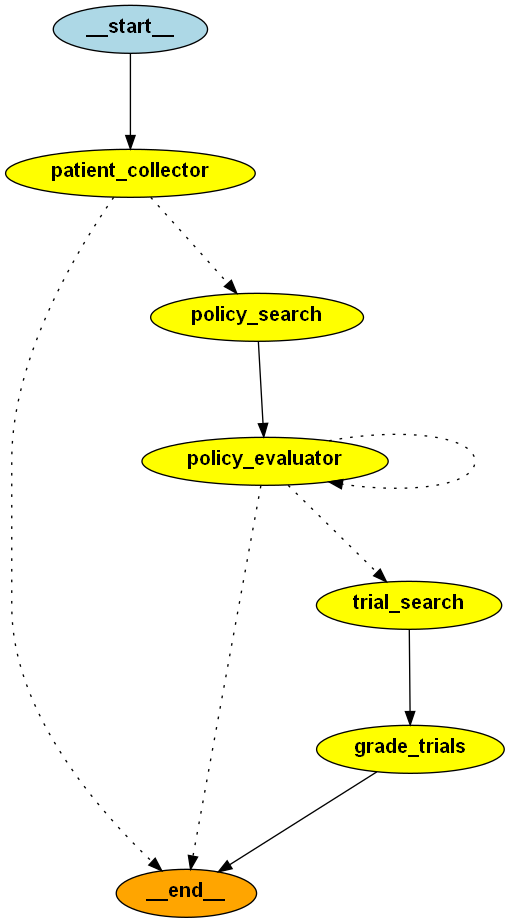

In [38]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.pydantic_v1 import BaseModel, Field
from operator import itemgetter
from typing import Literal
from langgraph.graph import StateGraph, END


model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost

memory = SqliteSaver.from_conn_string(":memory:")



# ------- Agents:
class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

# model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)  #reduce inference cost
patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""
# If you cannot find patient ID in the request text then return 10000 as response.

def patient_collector_node(state: AgentState):
    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    # print(response)
    print(f"Patient ID: {patient_id}")
    patient_data = get_patient_data(patient_id)
    print(patient_data)
    if result is not None:        
        if patient_data.get('name'):
            del patient_data['patient_id']
            del patient_data['name']
        patient_profile = chain_profile.invoke({'patient_data': patient_data})

    return {
        "last_node": "patient_collector",
        "patient_data": patient_data,
        "patient_profile": patient_profile,
        "patient_id": patient_id,
        "revision_number": state.get("revision_number", 1) + 1,
        'policy_eligible': 'N/A'
        }

def policy_search(state: AgentState) -> List[Document]:    
    question = f"""
    Does the following patient profile comply with the institutional policies?\n
    {patient_profile}
    """
    docs_retrieved = retriever_policy.get_relevant_documents(question)
    if docs_retrieved is None:
        docs_retrieved = retriever_policy.get_relevant_documents(question)
    return {
        "last_node": "policy_search",
        "policies": docs_retrieved,
        "unchecked_policies": docs_retrieved.copy(),
    }

from helper_functions import policy_evaluator


def policy_checker(state: AgentState, docs_retrieved: List[Document] = None):
    # Convert patient_data to string    
    
    docs_retrieved = policy_search(state)

    results = []
    for doc in docs_retrieved:
        policy = doc.page_content
        result = policy_evaluator(state['patient_profile'], policy)
        results.append(result)
    
    evaluations = ("\n\n"+7*"------------"+"\n\n")+("\n\n"+7*"------------"+"\n\n").join([result for result in results])
        
    class comply(BaseModel):
        """score and reason for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trial 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use N/A")

        class Config:
            schema_extra = {
                "example": {
                    "binary_score": 'yes',
                    "reason": "N/A",
                },
                "example 2": {
                    "binary_score": 'no',
                    "reason": "The patient is pregnant at the moment.",
                },                
            }

    prompt_evaluate = PromptTemplate(
        template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
            You task is to find if the patient is eligible for all trial policies.
            \n The following is a list of policy evaluations for the patient:
            \n\n {evaluations} \n\n
                            
            Give a binary 'yes' or 'no' score to indicate whether the patient is eligible for all clinical trials.\n
            If the patient is not eligible then also give the reason as a string.
            """,
        input_variables=["evaluations"],
    )

    llm_with_tool = model.with_structured_output(comply)

    chain = prompt_evaluate | llm_with_tool

    # print(f'today is: {date}')
    scored_result = chain.invoke(
        {
            "evaluations": evaluations,
            # "question": question, 
            # "context": docs, 
            # "date": date
            # "patient_data": patient_data
        }
    )
    # print(scored_result)
    # scored_result    
    state['policy_eligible'] = True
    if scored_result.binary_score == 'no':
        state['policy_eligible'] = False    
        state['rejection_reason'] = scored_result.reason
        # state['ask_expert'] = 'policy_checker'
    
    state['policies'] = docs_retrieved
    state['patient_profile'] = patient_profile
    state["revision_number"] = state.get("revision_number", 1) + 1

    return state

def trial_search(state: AgentState):
    """
    This node searches the trial database to retrieve a list of clinical trials that match the patient's medical history.
    """

    patient_profile = state['patient_profile']

    question = f"""
    Which trials are relevant to the patient with the following medical history?\n
    patient_profile: {patient_profile}
    """        
    docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
    
    return {
        'last_node': 'trial_search',
        'trials': docs_retrieved
        }

def grade_trials(state: AgentState, trials: List[Document] = None):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----- CHECKING THE TRIALS RELEVANCE TO PATIENT PROFILE ----- ")
    
    if trials is None:
        trials = state['trials']
    patient_profile = state['patient_profile']

    # Score each doc
    relevant_trials = []
    for trial in trials:
        doc_txt = trial.page_content
        trial_diseases = trial.metadata['diseases']
        nctid = trial.metadata['nctid']
        trial_score = retrieval_grader.invoke(
            {
                "patient_profile": patient_profile, 
                "document": doc_txt, 
                "trial_diseases": trial_diseases
            }
        )
            
        relevance_score = trial_score.relevance_score
        if relevance_score.lower() == "yes":
            print(f"---GRADER: TRIAL {nctid} RELEVANT---")            
            trial_score_dic = dict(trial_score)
            trial_score_dic['nctid'] = nctid            
            relevant_trials.append(trial_score_dic)
        else:
            print(f"---GRADER: TRIAL {nctid} NOT RELEVANT---")
    return {
        'last_node': 'trial_search',
        "relevant_trials": relevant_trials
        }
        
# ========= continue functions =========
def should_continue_patient(state: AgentState):
    # end = False
    if state.get("patient_data"):
        # print('patient data found')
        print(state.get("patient_profile", 'No profile generated'))
        return "policy_search"
    else:
        print('Patient data not found in the database')
        return END
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        return END        

def should_continue_policy(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')        
        return END
    more_policies = len(state["unchecked_policies"]) > 0
    if state["policy_eligible"]:
        if more_policies:
            print("-------------- Check the next policy --------------")
            return "policy_evaluator"
        else:
            print("-------------- Patient passed the general trials policies --------------")
            return "trial_search"
    else:
        print("Patient did not pass this policy.\n")
        print(state['checked_policy'].page_content)
        # print("Patient did not pass the general trials policies.\n")        
        print('Rejection Reason: ')
        nprint(state['rejection_reason'])
        print("You can correct the patient's medical profile if required.")
        # state['ask_expert'] = 'policy_check'
        # print("state['ask_expert'] = 'policy_check'")
        # return "expert"
        return END

def should_continue_expert(state: AgentState) -> Literal["policy_checker", END]:
    if state["policy_eligible"] == False:
        print('to policy check')
        next = "policy_checker"
        # state["ask_expert"] = ""
    else:
        next = END
        print('to end')
    return next

# ==== define graph nodes====

builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")
builder.add_node("patient_collector", patient_collector_node)
builder.add_node("policy_search", policy_search)
builder.add_node("policy_evaluator", policy_evaluator)
# builder.add_node("policy_checker", policy_checker)
builder.add_node("trial_search", trial_search)
builder.add_node("grade_trials", grade_trials)
# builder.add_node("expert", expert_node)

# retrieve = ToolNode([retriever_tool])
# builder.add_node("retrieve", retrieve)  # retrieval


# ===== define graph edges====
# builder.add_edge("patient_collector", "")
# builder.add_edge("patient_adder", "patient_collector")
builder.add_conditional_edges(
    "patient_collector", 
    should_continue_patient, 
    {END: END
    # "patient_collector": "patient_collector"
    ,"policy_search": "policy_search"
    # , "policy_checker": "policy_checker"
    # ,"patient_adder": "patient_adder"
    }
)

builder.add_conditional_edges(
    "policy_evaluator", 
    should_continue_policy, 
    {
    "trial_search": "trial_search"
    , "policy_evaluator": "policy_evaluator"
    , END: END
    }
)

builder.add_edge("policy_search", "policy_evaluator")
builder.add_edge("trial_search", "grade_trials")
# builder.add_edge("grade_trials", END)
builder.set_finish_point("grade_trials")


graph = builder.compile(
    checkpointer=memory
    # ,interrupt_before=["__end__"]
    # , interrupt_after=['patient_collector', 'policy_search', 'policy_evaluator', 'trial_search', 'grade_trials']
)

from IPython.display import Image

Image(graph.get_graph().draw_png())

In [1]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
sample_patient_id = 16
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
patient_data
# date

NameError: name 'get_patient_data' is not defined

In [380]:
thread = {"configurable": {"thread_id": "0"}}

list(graph.get_state_history(thread))
config = {
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
    # 'patient_prompt': "Is patient Max eligible for any medical trial?",
    "max_revisions": 10,
    "revision_number": 1,
}

response = graph.invoke(config, thread)

Patient ID: 32
{'patient_id': 32, 'name': 'John Johnson', 'age': 49, 'medical_history': 'Depression', 'previous_trials': 'NCT01611731', 'trial_status': 'Ongoing', 'trial_completion_date': None}
Patient is a 49-year-old with a history of depression. They have previously participated in the clinical trial NCT01611731, which is currently ongoing. No trial completion date is available. Based on their medical history, they may be eligible for trials focusing on mental health and depression treatments.
Evaluating Policy: 
#### 1. **General Eligibility Criteria**
   - **Age Restrictions**: Patients must be between 18 and 75 years old.
   - **Gender**: No restrictions unless specified by the trial protocol.
   - **Informed Consent**: All patients must provide informed consent prior to participation.
   - **Residency**: Patients must be residents of the country where the trial is conducted.
   - **Health Insurance**: Patients must have valid health insurance coverage.

-------------- Check the 

KeyboardInterrupt: 

In [436]:
langchain.debug = False

thread = {"configurable": {"thread_id": "1"}}
events_gen = graph.stream({
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
    # 'patient_prompt': "Is patient Max eligible for any medical trial?",
    "max_revisions": 10,
    "revision_number": 1,
}, thread)
for event in events_gen:
    print(event)
# event = events_gen.__next__()

Patient ID: 16
{'patient_id': 16, 'name': 'Emma Smith', 'age': 80, 'medical_history': 'pancreatic cancer', 'previous_trials': 'NCT04589611', 'trial_status': 'Completed', 'trial_completion_date': '2023-05-27'}
Patient is an 80-year-old with a history of pancreatic cancer. They have previously participated in the clinical trial NCT04589611, which has been completed as of May 27, 2023. Based on their medical history, they may be eligible for future pancreatic cancer clinical trials.
{'patient_collector': {'last_node': 'patient_collector', 'patient_id': 16, 'policy_eligible': 'N/A', 'patient_data': {'age': 80, 'medical_history': 'pancreatic cancer', 'previous_trials': 'NCT04589611', 'trial_status': 'Completed', 'trial_completion_date': '2023-05-27'}, 'patient_profile': 'Patient is an 80-year-old with a history of pancreatic cancer. They have previously participated in the clinical trial NCT04589611, which has been completed as of May 27, 2023. Based on their medical history, they may be el

KeyboardInterrupt: 

In [387]:
from helper_functions import fn_get_state, resume_from_state
states, state_next, state_last  = fn_get_state(graph, thread, vernose = False, next = 'policy_evaluator')
# states
# states[-3].next
# state_next = states[-3]
# print(state_next.next)
# state_next.values['patient_profile']
# states[1].next
# state_next.values
state = states[0]
state.values
# state.next
states
# patient_profile = states[0].values['patient_profile']
# nprint(patient_profile)
# states[0].values
# for s in state:
    # print(s)
# states[0].created_at
# docs = states[0].values['policies']


[StateSnapshot(values={'last_node': 'patient_collector', 'patient_prompt': 'Is patient 32 eligible for any medical trial?', 'patient_id': 32, 'patient_data': {'messages': [HumanMessage(content='multiply 2.5 by 4.5')], 'output': 'The result of multiplying 2.5 by 4.5 is 11.25.'}, 'patient_profile': 'Patient is a 49-year-old with a history of depression. They have previously participated in the clinical trial NCT01611731, which is currently ongoing. No trial completion date is available at this time. Based on their medical history, relevant medical trials may include those focusing on depression treatments or mental health interventions.', 'revision_number': 2, 'max_revisions': 10}, next=('policy_search',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef38741-26fb-62ca-8001-43f97bb7c0ea'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'patient_collector': {'last_node': 'patient_collector', 'patient_id': 32, 'patient_data': {'messages': [HumanMessage(content='multiply 2.5

In [327]:
skip_policy = False
profile_corection = True


if profile_corection:
    new_profile= """
    Patient is a 30-year-old with a history of mesothelioma. They have 
    previously participated in the clinical trial NCT04068836, which is 
    FINISHED 6 months ago. Based on their medical history, they may be eligible for other mesothelioma 
    clinical trials.
    """

    # add_to_profile = """
    # Exlusion term: ignore age limits in the policies.
    # """    
    state = states[1]
    # state.values['patient_profile'] = new_profile
    # branch_state = graph.update_state(state.config, state.values, as_node = None)
    # events = []
    # for event in graph.stream(None, branch_state):
    #     events.append(event)
    #     print(event)
    resume_from_state(graph, state, key = 'patient_profile', value = new_profile) # to continue with new profile

# patient_profile = state.values['patient_profile']

# new_profile = patient_profile + add_to_profile
# nprint(new_profile)

if skip_policy:
    state = states[1]
    # state.values
    state.values['policy_eligible'] = True
    state.values['unchecked_policies'].pop(0)
    # state.values['max_revisions'] = 10
    state.values['rejection_reason'] = 'N/A'
    resume_from_state(graph, state, key = None, value = None , as_node = "policy_evaluator") # go to next policy        
# state.values

# resume_from_state(graph, state)
# resume_from_state(graph, state, key = 'patient_profile', value = new_profile) # to continue with new profile
# resume_from_state(graph, state, key = 'patient_profile', value = new_profile , as_node = "policy_evaluator")
# resume_from_state(graph, state, key = None, value = None , as_node = "policy_evaluator") # go to next policy
# branch_and_add = graph.update_state(state.config, state.values, as_node="policy_evaluator")

Evaluating Policy: 
#### 1. **General Eligibility Criteria**
   - **Age Restrictions**: Patients must be between 18 and 75 years old.
   - **Gender**: No restrictions unless specified by the trial protocol.
   - **Informed Consent**: All patients must provide informed consent prior to participation.
   - **Residency**: Patients must be residents of the country where the trial is conducted.
   - **Health Insurance**: Patients must have valid health insurance coverage.

-------------- Check the next policy --------------
{'policy_evaluator': {'last_node': 'policy_evaluator', 'patient_prompt': 'Is patient 16 eligible for any medical trial?', 'patient_id': 16, 'policy_eligible': True, 'rejection_reason': 'N/A', 'patient_data': {'patient_id': 16, 'name': 'Emma Smith', 'age': 80, 'medical_history': 'pancreatic cancer', 'previous_trials': 'NCT04589611', 'trial_status': 'Completed', 'trial_completion_date': '2023-05-27'}, 'patient_profile': '\n    Patient is a 30-year-old with a history of mes

### HIL

Continue from modified state

In [378]:
new_profile = """
'Patient is a 74-year-old with a history of Chronic Pain. 
They have previously participated in the clinical trial NCT07600953, which is currently completed. 
Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain conditions.'
"""

# events = resume_from_state(graph, state_next, 'patient_profile', new_profile)
events = resume_from_state(graph, state_next)

# result = policy_checker(state_next.values)
# result = policy_checker(state_next.values, [doc])
# print(result['policy_eligible'])
# if 'rejection_reason' in result:
    # nprint(result['rejection_reason']) 



-------------- Check the next policy --------------
--------- continue from modified state ---------
-------------- Check the next policy --------------
{'policy_evaluator': {'patient_prompt': 'Is patient 20 eligible for any medical trial?', 'patient_id': 20, 'policy_eligible': True, 'rejection_reason': 'N/A', 'patient_data': {'patient_id': 20, 'name': 'Alice Doe', 'age': 60, 'medical_history': 'myeloma', 'previous_trials': 'NCT01391532', 'trial_status': 'Completed', 'trial_completion_date': '2023-01-19'}, 'patient_profile': 'Patient is a 60-year-old with a history of myeloma. They have previously participated in the clinical trial NCT01391532, which was completed on January 19, 2023. Based on their medical history, they may be eligible for ongoing clinical trials for myeloma treatment.', 'revision_number': 5, 'max_revisions': 6, 'policies': [Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   -

Let's look at the trials

In [43]:
# if event has the key grade_trials
if "grade_trials" in event:
    if len(event['grade_trials']['relevant_trials'])>0:
        # convert to dataframe
        df_trials_relevant = pd.DataFrame(event['grade_trials']['relevant_trials'])
        for i, row in df_trials_relevant.iterrows():
            print('==== evaluaiton of trial', row['nctid'])
            print('explanation:')
            nprint(row['explanation'])
            print('Required information:')
            nprint(row['further_information'])
else:
    print('The trial_grader was not reached!')

df_trials_relevant



==== evaluaiton of trial NCT02366819
explanation:
('The patient has a history of esophagogastric adenocarcinoma, which is one of '
 "the diseases included in the trial's inclusion criteria. Therefore, the "
 "trial is relevant to the patient's medical profile.")
Required information:
("Additional information needed from the patient's medical history includes "
 'current ECOG performance status, recent blood test results for ANC, '
 'hemoglobin, platelets, total bilirubin, SGOT, SGPT, and creatinine levels. '
 'It would also be important to know if the patient has any concurrent medical '
 'conditions or is taking any medications that may affect eligibility for the '
 'trial.')


,relevance_score,explanation,further_information,nctid
0,Yes,The patient has a history of esophagogastric a...,Additional information needed from the patient...,NCT02366819


In [61]:
states, state_next, state_last = fn_get_state(graph, thread, vernose = False, next = 'policy_checker')
nctid = state_last.values['relevant_trials'][0]['nctid']
df_trials[df_trials['nctid'] == nctid]['diseases'].values[0]
df_trials[df_trials['nctid'] == nctid]['criteria'].values[0]
doc = state_last.values['trials'][-1]
doc

Document(page_content="\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed locally advanced gastric (primary endpoint includes proximal\r\n             and mid-body stomach) or esophagogastric adenocarcinoma; distal gastric (antral)\r\n             adenocarcinomas are eligible for enrolment but will not be included in the primary\r\n             analysis\r\n\r\n          -  Locally advanced disease as determined by endoscopic ultrasound (EUS) stage > primary\r\n             tumor (T) 3 and/or any T, lymph nodes (N)+ disease without metastatic disease (Mx)\r\n\r\n          -  All patients must have diagnostic laparoscopy with diagnostic washings for cytology;\r\n             both cytology positive and negative patients are eligible for enrolment, but only\r\n             cytology negative patients will be included in the primary analyses; gross peritoneal\r\n             disease is not eligible\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performa

In [86]:
# state = states[0].values
state_next = states[1]
# state_next = state_last
state_next.values['patient_profile'] = """
Patient is a 74-year-old with a history of Chronic Pain in the chest. 
They have previously participated in the clinical trial NCT07600953, which is currently completed. 
Based on their medical history, they may be eligible for trials focusing on pain management or chronic chest pain conditions"
"""
result = grade_trials(state_last.values)
result

----- CHECKING THE TRIALS RELEVANCE TO PATIENT PROFILE ----- 
---GRADER: TRIAL NCT02737787 NOT RELEVANT---
---GRADER: TRIAL NCT01485861 NOT RELEVANT---
---GRADER: TRIAL NCT03306264 NOT RELEVANT---
---GRADER: TRIAL NCT02366819 NOT RELEVANT---


{'relevant_trials': []}

In [85]:
branch_state = graph.update_state(state_next.config, state_next.values)
print("--------- continue from modified state ---------")
events = []
for event in graph.stream(None, branch_state):    
    events.append(event)
    print(event)


--------- continue from modified state ---------
Patient ID: 32
Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain treatments.
{'patient_collector': {'patient_id': 32, 'patient_data': {'patient_id': 32, 'name': 'Michael Thomas', 'age': 77, 'medical_history': 'Chronic Pain', 'previous_trials': 'NCT07600953', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'patient_profile': 'Patient is a 77-year-old with a history of Chronic Pain. They have previously participated in the clinical trial NCT07600953, which is currently ongoing. Based on their medical history, they may be eligible for trials focusing on pain management or chronic pain treatments.', 'revision_number': 4}}
max revision reached
{'policy_checker': {'patient_prompt': 'Is patient 32 eligible for any medical tri

## HIL
To correct Patient's data to pass the eligibility check.

In [ ]:
state = states[1]
state.values
# for k in state:
#     print(k)


# state.values["patient_data"]['trial_status'] = None
# state.values["patient_data"]['previous_trials'] = None
branch_state = graph.update_state(state.config, state.values)
print(branch_state)
# state


print("--------- continue from modified state ---------")
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

# for event in graph.stream({
#     'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
#     # 'patient_prompt': "Is patient Max eligible for any medical trial?",
#     "max_revisions": 2,
#     "revision_number": 1,
# }, thread):
#     print(event)

patient data found
{'patient_id': 8, 'name': 'James Thomas', 'age': 49, 'medical_history': 'lymphoblastic leukemia', 'previous_trials': 'Trial 18', 'trial_status': 'Completed', 'trial_completion_date': '2023-11-06'}
{'configurable': {'thread_id': '1', 'thread_ts': '1ef31789-5527-6dad-8002-b9d01aab14fd'}}
--------- continue from modified state ---------
today is: 2024-06-23
binary_score='no' reason='The patient has participated in a previous trial (Trial 18) within the last 5 months, which violates the policy of not participating in any other clinical trial within the least 5 months prior to enrolling in a new trial.'
Patient did not pass the general trials policies
{'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': False, 'rejection_reason': 'The patient has participated in a previous trial (Trial 18) within the last 5 months, which violates the policy of not participating in any other clinical trial within the least 5 months prior to

# Application GUI

In [ ]:
thread = {"configurable": {"thread_id": "0"}}
states = list(graph.get_state_history(thread))
# states[0].next
policy_doc = states[0].values['policies'][0]
# policy_header = policy_doc.page_content.split('\n', 2)[:2]
policy_doc.page_content.split('\n', 2)[1]
# print(f'Evaluating Policy: {policy_header}')
# for s in states:
    # print(s.values['last_node'],s.next )
# states

In [46]:
import sys
module_dir = os.path.abspath('../../temp/langgraph')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_fns2 import writer_gui

# class AgentState(TypedDict):
#     task: str
#     plan: str
#     draft: str
#     critique: str
#     content: List[str]
#     revision_number: int
#     max_revisions: int

# MultiAgent = ewriter()
# app = writer_gui(MultiAgent.graph)
memory = SqliteSaver.from_conn_string(":memory:")

# memory.chat_memory.clear()
graph = builder.compile(
    checkpointer=memory
    # ,interrupt_before=["__end__"]
    # , interrupt_after=['patient_collector', 'policy_search', 'policy_evaluator', 'trial_search', 'grade_trials']
    , interrupt_after=[ 'trial_search', 'grade_trials']
)
# graph.clear()
patient_prompt = f"Is patient {16} eligible for any medical trial?"
thread = {"configurable": {"thread_id": "0"}}
config = {'patient_prompt': patient_prompt,"max_revisions": 6,"revision_number": 0,
                      'last_node': "", 'planner': "no plan", 'draft': "no draft", 'critique': "no critique", 
                      'content': ["no content",], 'queries': "no queries", 'revision_number':0}
# state = list(graph.get_state_history(thread))
if 1==2:
    response = graph.invoke(config, thread)

    current_states = list(graph.get_state_history(thread))
    asnode = 'policy_search'
    print(current_states)
    current_values = current_states[0]
    current_values.values['patient_profile'] = 'test value'
    graph.update_state(thread, current_values.values, as_node = asnode)
    current_state = list(graph.get_state_history(thread))[0]
    print(current_state.next)
else:
    if app is not None:
        app.demo.close()
    app = writer_gui(graph)    
    app.demo.launch(server_name="127.0.0.1", server_port=7959)


OSError: Cannot find empty port in range: 7959-7959. You can specify a different port by setting the GRADIO_SERVER_PORT environment variable or passing the `server_port` parameter to `launch()`.

In [ ]:
import sys
module_dir = os.path.abspath('../../temp/langgraph')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_fns import ewriter, writer_gui

MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

In [477]:
# Define the Gradio interface components
patient_prompt = gr.Textbox(label="Patient ID", placeholder="Specify the patient here, e.g., Is patient 32 eligible for any medical trial?")
last_node = gr.Textbox(label="Last Node")
next_node = gr.Textbox(label="Next Node")
thread = gr.Textbox(label="Thread")
draft_rev = gr.Textbox(label="Draft Rev")
count = gr.Textbox(label="Count")
start_evaluation_btn = gr.Button("Start Evaluation")
continue_evaluation_btn = gr.Button("Continue Evaluation")

live_agent_output = gr.Textbox(label="Live Agent Output", lines=5, max_lines=5)

# Create the Gradio interface
def trial_management_agent():
    with gr.Blocks() as demo:
        with gr.TabItem("Main"):
            with gr.Row():
                patient_prompt.render()
                start_evaluation_btn.render()
                continue_evaluation_btn.render()
        
            # with gr.Row():
            #     last_node.render()
            #     next_node.render()
            #     thread.render()
            #     draft_rev.render()
            #     count.render()
        
            with gr.Row():
                live_agent_output.render()
        
            start_evaluation_btn.click(start_evaluation, inputs=[patient_prompt], outputs=[live_agent_output], show_progress=True)
            # continue_evaluation_btn.click(continue_evaluation, inputs=[patient_id, last_node, next_node, thread, draft_rev, count], outputs=live_agent_output)

        # with gr.TabItem("Patient Profile"):
        #     patient_profile_output = gr.Textbox(label="Patient Profile", interactive=False)
        #     patient_profile_output.render()
        #     patient_profile_output.update(show_patient_profile)

        # with gr.TabItem("Policy Evaluator"):
        #     policy_evaluations_output = gr.Textbox(label="Policy Evaluations", interactive=False)
        #     policy_evaluations_output.render()
        #     policy_evaluations_output.update(show_policy_evaluations)

        # with gr.TabItem("Trial Grader"):
        #     trial_grading_output = gr.Textbox(label="Trial Grading", interactive=False)
        #     trial_grading_output.render()
        #     trial_grading_output.update(show_trial_grading)

    return demo

def start_evaluation(patient_prompt):
    print(patient_prompt)
    initial_state = {
        'patient_prompt': patient_prompt,    
        "max_revisions": 10,
        "revision_number": 1,
    }
    thread = {"configurable": {"thread_id": "1"}}
    graph = builder.compile(
        checkpointer=memory
        # ,interrupt_before=["__end__"]
        # , interrupt_after=["expert"]
    )
    print(graph)
    thread = {"configurable": {"thread_id": "1"}}
    result = graph.stream({
        'patient_prompt': f"Is patient 16 eligible for any medical trial?",
        # 'patient_prompt': "Is patient Max eligible for any medical trial?",
        "max_revisions": 10,
        "revision_number": 1,
    }, thread)
    # for event in events_gen:
        # print(event)

    # result = None
    return result

demo = trial_management_agent()
# demo.launch()
demo.close()

Patient ID: 16
{'patient_id': 16, 'name': 'Emma Smith', 'age': 80, 'medical_history': 'pancreatic cancer', 'previous_trials': 'NCT04589611', 'trial_status': 'Completed', 'trial_completion_date': '2023-05-27'}
Patient is an 80-year-old with a history of pancreatic cancer. They have previously participated in the clinical trial NCT04589611, which has been completed as of May 27, 2023. Based on their medical history, they may be eligible for future pancreatic cancer clinical trials.
Evaluating Policy: ['', '#### 1. **General Eligibility Criteria**']
Patient did not pass this policy.


#### 1. **General Eligibility Criteria**
   - **Age Restrictions**: Patients must be between 18 and 75 years old.
   - **Gender**: No restrictions unless specified by the trial protocol.
   - **Informed Consent**: All patients must provide informed consent prior to participation.
   - **Residency**: Patients must be residents of the country where the trial is conducted.
   - **Health Insurance**: Patients mu